# CS 345 Project
#### _Ben Spencer and Matteo Selvaggio_

### **Part 0: Introduction, Importing Data, and Libraries**

##### **Topic Introduction**
The topic we selected to explore is classical game theory. Machine learning and AI has a strong history with classical games such as Go and Chess since most classical games have a finite number of continuous moves and can technically be "solved" if given enough time and game knowledge. There have been many examples of expectional AI models that have been used to play and study various games, including AlphaGo for Go and Stockfish for chess.

To explore this topic, we wanted to find out if a model could be trained simply to determine what the next best move should be in the game of chess. Typically, most models that determine the next best move utilize a variety of different parameters in combination with chess theory to come up with accurate predictions. Our initial goal, however, would be to train a model with only game board data and find out how accurately it could predict what the next best move might be.

##### **Data Description**
The [dataset](https://database.lichess.org/#puzzles) being used is a dataset from the popular chess website Lichess. The data itself contains a variety of features related to over 3,000,000 chess puzzles that are available to play online. The list of available features are as follows:

* *PuzzleId* (The ID number corresponding to the puzzle)
* *FEN* (An encoding of the board state at the start of the puzzle)
* *Moves* (A list of moves required to solve the puzzle)
* *Rating* (Chess ELO rating level of the puzzle) 
* *RatingDeviation* (The deviation in ELO rating between the two players in the puzzle)
* *Popularity* (Average upvotes and downvotes of the puzzle) 
* *NbPlays* (Number of times the puzzle has been played on Lichess)
* *Themes* (A list of tags that describe the characteristics of the game in the puzzle)
* *GameUrl* (Link to the Lichess website for the puzzle)
* *OpeningTags* (If the puzzle is withing the first 20 moves of the game, describes the opening of the current game)

In the case of the model we are trying to train, we had decided to rule out using most of the data columns with the exception of the FEN and Moves columns. From the FEN data, we are able to obtain a value for the current board state which will be used as the X input vector for the model. Conversely, the Moves list will contain the next best move required to solve the puzzle, which will be used as our output or label vector.

Finally, since the data contains over 3,000,000 data points, training the model on the entire dataset would be very computational intense. Therefore, we shortened the datasets overall size to the first 30,000 entries to make running and training each model faster.

In [1]:
# installing zstandard package to unpack .zst compressed files
# %pip install zstandard
import zstandard as zstd

# installing chess package which contains useful methods for processing chess boards.
# %pip install chess
import chess

# importing numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

# importing sklearn methods
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

# importing keras with GPU
# If using Anaconda, use the following commands in a local conda terminal:
# %pip install --upgrade pip
# %conda create -n tf tensorflow
# %conda activate tf
# %pip install tensorflow[and-cuda]
#import tensorflow as tf

# import data
# the usecols parameter extracts the PuzzleID, FEN, and Game Moves columns only
# the skiprows parameter only receives the last 10,000 entries
fen_data = np.loadtxt("lichess_db_puzzle.csv", delimiter=',', dtype=str, skiprows=3032157, usecols=(1))
move_list = np.loadtxt("lichess_db_puzzle.csv", delimiter=',', dtype=str, skiprows=3032157, usecols=(2))
print(f'Shape of the features array (X): {fen_data.shape}')
print(f'Head of the features array: {fen_data[:5]}\n')
print(f'Shape of the labels array (Y): {move_list.shape}')
print(f'Head of the labels array: {move_list[:10]}')


Note: you may need to restart the kernel to use updated packages.
Shape of the features array (X): (800000,)
Head of the features array: ['4rrk1/ppp2ppp/6q1/4p3/4Nn2/2PP1Q2/PP3PP1/R1B2RK1 w - - 6 20'
 '8/8/4k3/1pp1P3/5K1p/PP5P/8/8 w - - 0 59'
 '8/5Bpp/2k5/p7/P2K4/5P2/2b4P/8 b - - 0 36'
 '8/5pp1/3N3p/3P4/3k2P1/1b5P/1P3PK1/8 w - - 0 41'
 '8/8/5Np1/8/5k1P/1r6/6PK/8 b - - 1 58']

Shape of the labels array (Y): (800000,)
Head of the labels array: ['f3g3 f4e2 g1h2 e2g3' 'a3a4 c5c4 a4a5 c4b3 a5a6 b3b2 a6a7 b2b1q'
 'c2a4 f7e8 c6d6 e8a4' 'd6f7 b3d5 g2g3 d5f7' 'b3b6 f6d5 f4g4 d5b6'
 'c2d3 b2f2' 'd5b7 d6b4 e2d2 b4b7' 'e5g5 f6f8 d8f8 f1f8 g8f8 g6d6'
 'f6e4 d1a4 b8c6 a4e4' 'a5a6 b4e4 d3e4 f5g3 h1g2 g3e4']


#### **Part 1: Organizing the Data**

#### Decription and Analysis: Organizing Data

The first step of our project was to organize the data into input vectors and output vectors that could be
processed by a machine learning model. For the input, the Python chess library has a method capable of
converting FEN data into a string representation of a chess board. This representation contains periods
where there are empty spaces and labels of where each individual piece lies on the board. Using this
string, we created a function that converts each square of the board position into a vectorized value, the
template of which is described in the commented block below. The resulting input matrix has a shape of
30000 x 64 x 12 before being flattened. This corresponds to the size 12 vector representation for each of
the 64 board spaces and for each of the 30000 datapoints.

Alternatively, the output of the function is equivalent to the space on the board that should be moved
according to the puzzle solution. This can be represented using the first two characters of the move list
string feature of the dataset. Therefore, a numerical value can be set to each space on the board,
turning the model into a 64-class classification problem. The ways in which numerical values are
assigned to board positions are also described in the commented block above the rank() and file()
functions.

In [2]:
'''
Contains some example code that will be helpful for organizing data.

board_matrix = []

for i in range(10000):
    board_matrix.append(str(chess.Board(fen_data[i,1])))

label = []

for i in range(10000):
    label.append(move_list[i][2:4])

print(label[:5])
'''
data_size = len(move_list)
board_size = 64

def convert_board_to_str(fen):
    rtn = str(chess.Board(fen))
    return rtn

'''
The following function converts characters in the board position to vectors of size 12 to indicate what kind of
piece is in that space. Here is the template:

No piece:               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Black Pawn (p):         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Black Knight (n):       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Black Bishop (b):       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Black Rook (r):         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Black Queen (q):        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
Black King (k):         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

White Pawn (P):         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
White Knight (N):       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
White Bishop (B):       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
White Rook (R):         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
White Queen (Q):        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
White King (K):         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
'''
def convert_str_to_vector(board_data):
    rtn = []

    for i in range(len(board_data)):
        x = board_data[i]

        if x == ' ' or x == '\n':
            continue
        elif x == '.':
            rtn.append([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        elif x == 'p':
            rtn.append([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        elif x == 'n':
            rtn.append([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        elif x == 'b':
            rtn.append([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        elif x == 'r':
            rtn.append([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
        elif x == 'q':
            rtn.append([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
        elif x == 'k':
            rtn.append([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
        elif x == 'P':
            rtn.append([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
        elif x == 'N':
            rtn.append([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
        elif x == 'B':
            rtn.append([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
        elif x == 'R':
            rtn.append([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
        elif x == 'Q':
            rtn.append([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
        elif x == 'K':
            rtn.append([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
        else:
            # For debugging
            print(f'ERROR: Board Contains Unnaccepted Character: {board_data[i]}')
            break

    return rtn

'''
The following functions will convert the position of a piece in chess (i.e., a4) to a 
numerical value to be used by a classifier.

A rank is considered a horizontal row and a file is a vertical column. Values for each
square are numbered in order from left to right, top to bottom, numbered 0-63.

For example, the space a1 would be assigned the value '0' and the space h8 would be 
assigned the value '63'.
'''
def rank(char):
    if char == 'a':
        return 0
    elif char == 'b':
        return 8
    elif char == 'c':
        return 16
    elif char == 'd':
        return 24
    elif char == 'e':
        return 32
    elif char == 'f':
        return 40
    elif char == 'g':
        return 48
    elif char == 'h':
        return 56
    else:
        raise Exception(f'ERROR: Unsupported rank character: {char}')
    
def file(char):
    if int(char) > 0 and int(char) <= 8:
        return (int(char) - 1)
    else:
        raise Exception(f'ERROR: Unsupported file character: {char}')

def convert_pos_to_val(pos):
    val = 0

    val += rank(pos[0])
    val += file(pos[1])
    return val


In [3]:
# Converting FEN data to serialized vector data
X_list = []
board_pos = np.arange(board_size)

for i in range(data_size):
    board_data = convert_board_to_str(fen_data[i])
    board_pos = convert_str_to_vector(board_data)
    X_list.append(board_pos)

X = np.array(X_list)
X.shape

# Converting move list to two label vectors for each model
labels = []

for i in range(data_size):
    val = convert_pos_to_val(move_list[i][:2])
    labels.append(val)

y_move_from = np.array(labels)

labels = []

for i in range(data_size):
    val = convert_pos_to_val(move_list[i][2:4])
    labels.append(val)

y_move_to = np.array(labels)

### Part 2 : Base Models

#### Description: Base Models

The two models that we selected for our base performance were the Random Forest and SVM models.
Each of these models were initially run with the data on base configurations with no hyperparameter
tuning. To make the data more easily processed by the model, the input matrix was flattened into a
30000 x 768 matrix so that each of the 64 positions in a datapoint could be represented as a single
vector

In [5]:
#Reshaping Data for Base Models
X_reshaped = X.reshape(X.shape[0], -1)
X_reshaped.shape

(30000, 768)

#### Random Forest

#### Description: Random Forest

Training of the base model was done using the cross_val_score() function provided by sklearn. The
cross-validation parameter was generated using a Stratified K-Fold with 5 splits and shuffled data so that
the model could look at a larger variety of both training and test data. The resulting model presented
very low accuracy but performed better than the 0.02 accuracy that would be generated from selecting
a point on the board at random to move from. Additionally, the standard deviation of scores for this
model was very low, which implies that the model was consistently reaching the given accuracy across
all folds

In [6]:
#Running a stratified k-fold cross validation on random forest classifier model
rf_classifier = RandomForestClassifier()
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
accuracy_rf = cross_val_score(rf_classifier, X_reshaped, y_move_from, cv=cv, scoring='accuracy') 

In [7]:
print("Mean score:", np.mean(accuracy_rf))
print("Standard deviation of scores:", np.std(accuracy_rf))

Mean score: 0.1591333333333333
Standard deviation of scores: 0.003736308338453883


#### SVM

#### Description: SVM

Training of the SVM model was done using the same method and cross-validation parameters as the
Random Forest training. Accuracy of the SVM with no hyperparameter adjustments was almost identical
to the Random Forest model. The standard deviation between scores was only marginally smaller than
the Random Forest models, implying that the SVM model is slightly more consistent with generating
accuracies than the Random Forest.

In [ ]:
#Benchmarking for optimal c values and optimal kernel for soft margin SVM.
svm_classifier = SVC()
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
accuracy_svm = cross_val_score(svm_classifier, X_reshaped, y_move_from, cv=cv, scoring='accuracy') 

In [9]:
print("Mean score:", np.mean(accuracy_svm))
print("Standard deviation of scores:", np.std(accuracy_svm))

Mean score: 0.1582333333333333
Standard deviation of scores: 0.0026174627239200702


#### Analysis: Base Models

From here, we needed to decide if we should continue to pursue improving the base models as the final model or if
we should pursue a new model all together. Research showed some success with creating chess AI using
a deep neural network, which is something our group tested and explored:

[Sayon Bhattacharjee](https://towardsdatascience.com/predicting-professional-players-chess-moves-with-deep-learning-9de6e305109e)

[Erik Bernhardsson](https://erikbern.com/2014/11/29/deep-learning-for-chess.html)

Through experimentation, however, we decided that pursuing a neural network would be
computationally infeasible for the scope of this project. The model shown above was trained on input
with over 100 million datapoints and with node parameters surpassing 7 million for each hidden layer.
Due to the sheer amount of data needed to properly train a neural network, it was likely that the neural
network would not outperform either the SVM or Random Forest models.

Instead, we decided which of the two models had the most room for improvement. In terms of the
number of available hyperparameters to adjust, the SVM has more available settings to tune than the
Random Forest, which would imply that it has a greater chance of seeing improvement. Therefore, to
increase the accuracy of the model, we decided to investigate how the SVM could be improved to
generate more accurate results than the base model.

### Fine Tuned Models

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [4]:
#Reshaping Data for Fine Tuned Models
X_reshaped = X.reshape(X.shape[0], -1)
X_reshaped.shape

(800000, 768)

#### Decription: GridSearch

The first step in improving the SVM model was to analyze which parameters should be set for each of
the available SVM settings. We looked at different combinations of values for three different
parameters:

- Kernels: We decided to test two of the most popular non-linear kernels since we assume a linear
kernel will fail to classify the data properly. The two kernels we selected are the Sigmoid kernel
and RBF or Gaussian kernel. Each of these kernels will assist in transforming the data and will
generate boundaries that can better fit the non-linearity of the data.
- The C Value: We selected three of the most common C values that are used in SVM models to
determine the hardness or softness of the margins generated by the model. Setting the value to
a 1 would imply a very loose boundary with few punishments on misclassifications while setting
the value to 100 would restrict the number of misclassifications allowed in the training of the
model.
- Gamma: This is a parameter to decide the shape of the curve used to transform the data. In the
case of the RBF kernel, a smaller value implies a steeper curve while a larger value creates a
broader and wider curve. For a Sigmoid function, lower gamma values will flatten the curve
while higher gamma values will add greater severity and steeper change between the low and
high values of the curve.

To test each of these parameters, a GridSearchCV was performed with a small validation set to help
determine which parameter combination would generate the highest improvement in predicting the
overall data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_move_from, test_size=0.2, random_state=42)

In [14]:
hyperparameters = {
    'C': [1, 10, 100],
    'kernel': ['rbf', 'sigmoid'],
    'gamma': [0.001, 0.01, 0.1, 1]
}

_, X_train_val, _, y_train_val = train_test_split(X_train, y_train, test_size=0.01, random_state=42)

In [15]:
classifier = SVC()
grid_search = GridSearchCV(classifier, hyperparameters)
grid_search.fit(X_train_val, y_train_val)
best_parameters = grid_search.best_params_
print("Best hyperparameters: ", best_parameters)

Best hyperparameters:  {'C': 100, 'gamma': 0.001, 'kernel': 'sigmoid'}


#### Analysis: GridSearch

The results determined that for the validation set, the best set of hyperparameters are to use a Sigmoid
kernel, a high C value to establish somewhat strict decision boundary, and low gamma value to loosen
the differences between high and low values.

In [16]:
classifier_opt = SVC(C = 100, gamma = 0.001, kernel = 'sigmoid')
classifier_opt.fit(X_train, y_train)

SVC(C=100, gamma=0.001, kernel='sigmoid')

In [21]:
#Decreasing data size for testing due to resource intensive predict()
_, X_test_feasible, _, y_test_feasible = train_test_split(X_test, y_test, test_size=0.01, random_state=42)
y_pred_opt = classifier_opt.predict(X_test_feasible)
accuracy_opt = accuracy_score(y_test_feasible, y_pred_opt)
print("Optimized Model Accuracy: ", accuracy_opt)

Optimized Model Accuracy:  0.233125


#### Analysis: Final Model

For our final model, we chose the SVM because of its higher optimization capabilities. Furthermore, we pushed our computational resources by increasing the input data by an order of magnitude. We see a significant increase in model accuracy to approximately 23 percent. I say significant despite this only being an increase of 7 percent because other hyperparameter tuning done prior to this final model with less data only achieved increases of approximately 0.005 or 0.5%. The main hurdle to this Machine Learning problem is data set size. Similarly to this, when we attempted to train Neural Networks of varying architectures and hyper parameters, no matter how long we ran the model or how much we tuned the hyperparameters, we never obtained any growth in the model. It stayed stagnant. I believe this was also due to us not supplying it with enough data.

This is more than likely due to the abstract nature of this problem. There are so many deeper objectives and rulesets for the model to understand about chess that we don't give it the time to learn, time in this case being data points. I would wager to guess that even if we had trained our final model with the entire dataset available to us from the Lichess database, we still wouldn't capture all the important intricacies this model would have to pay attention to.

With this understanding, we are impressed at the capability of a simple classifier like an SVM. With significant training data and tuning of the model, we were able to approach 25% accuracy on piece to move decision making.

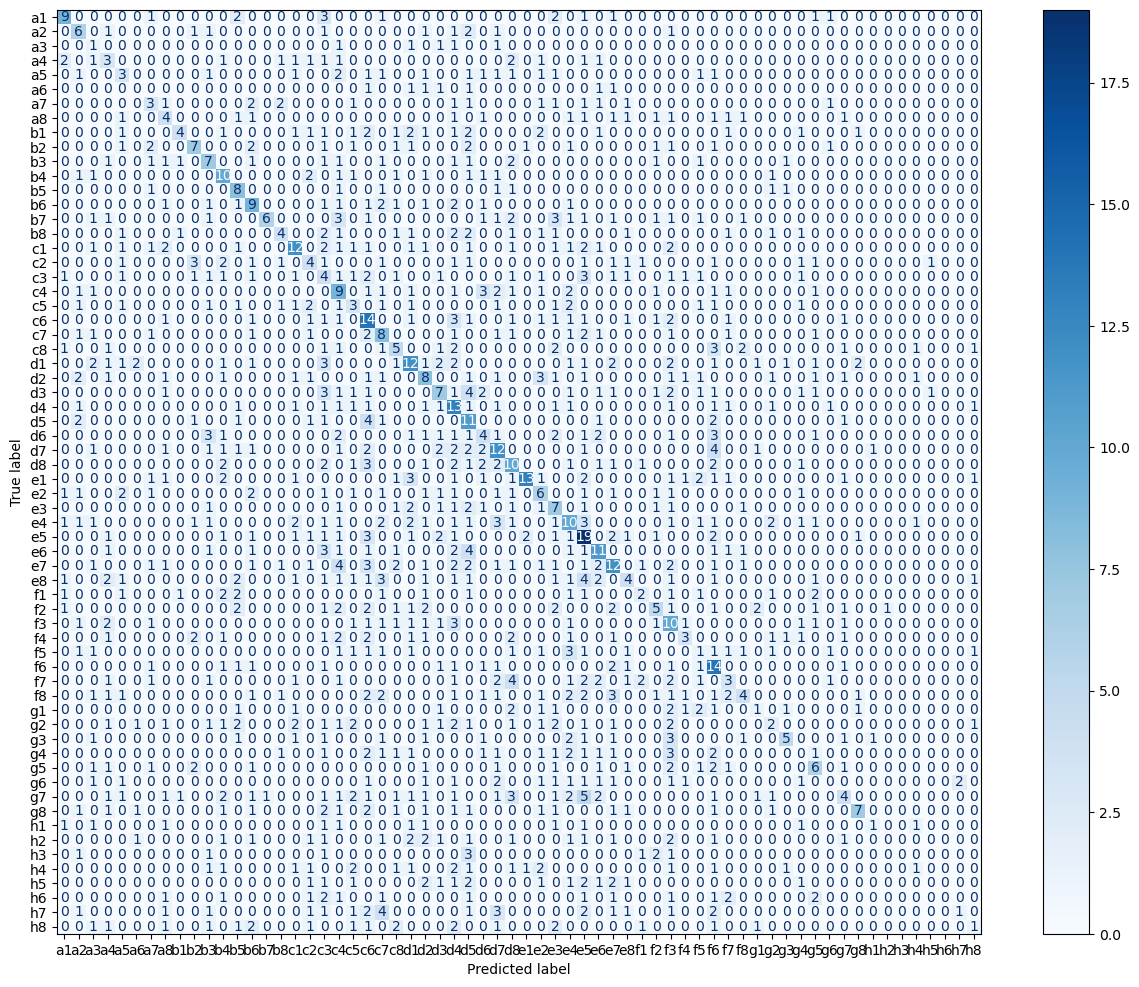

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
ranks = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
classifications = []
for rank in ranks :
    for i in range(1, 9) :
        classifications.append(rank + str(i))

matrix = confusion_matrix(y_test_feasible, y_pred_opt)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=classifications)
fig, ax = plt.subplots(figsize=(16,12))
display.plot(ax=ax, include_values=True, cmap=plt.cm.Blues)

#### Conclusion

Though this is a little harder to interpret, a few key interpretations can be understood from this Confusion Matrix. Firstly, the perspective of the player is forced within our data. Therefore, the player's side of the game board starts on 1, the opponent's side ends on 64. Due to this, we see trends that would make sense with this interpretation. Firstly, the highest quantity of correct predictions falls around the center of the board. This is consistent with Chess game theory as controlling territory in the center of the board is the first tactic one learns after learning the basic rules of the game. This is most evident with the highest predicted and most accurate spot on the board is e5, generally the strongest square the board next to e4.

Furthermore, We see that high value pieces are being focused on as well, such as a1, a rook on the queen side of the board, a generally attacking rook as the other is often used to protect the king after castling. This is evident for high readings on positions like e1 and d1 as well, being our queen and bishops, powerful developing pieces.

Finally, as expected, we have a concentration of miscalculations around both of these important points of play. We see an almost concentration of misclassifications around the center of the board, generally where the most effective moves take place. Though this is a little far fetched to state, from these observations we can state that the model has learned the concept of center control, one of the foundational concepts of chess game theory.

With our limited resources this is seen as a significant accomplishment.